In [ ]:
import requests
import pandas as pd
import numpy as np  
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import os
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
%matplotlib inline

In [ ]:
API_KEY = 'your_api_key'
BASE_URL = 'https://api.rawg.io/api/games'

ngames = 5000  

def fetch_all_games(max_games=ngames):
    all_games = []
    page = 1
    while len(all_games) < max_games:
        params = {
            'key': API_KEY,
            'page': page,
            'page_size': 20,  
        }
        response = requests.get(BASE_URL, params=params)
        data = response.json()
        
        if not data['results']:
            break  
        
        all_games.extend(data['results'])
        page += 1 

    return pd.DataFrame(all_games)

games_df = fetch_all_games(max_games=ngames)


print(f'Total games fetched: {len(games_df)}')
print(games_df.head())


Total games fetched: 5000
     id                             slug                              name  \
0  3498               grand-theft-auto-v                Grand Theft Auto V   
1  3328          the-witcher-3-wild-hunt          The Witcher 3: Wild Hunt   
2  4200                         portal-2                          Portal 2   
3  4291  counter-strike-global-offensive  Counter-Strike: Global Offensive   
4  5286                      tomb-raider                Tomb Raider (2013)   

     released    tba                                   background_image  \
0  2013-09-17  False  https://media.rawg.io/media/games/20a/20aa03a1...   
1  2015-05-18  False  https://media.rawg.io/media/games/618/618c2031...   
2  2011-04-18  False  https://media.rawg.io/media/games/2ba/2bac0e87...   
3  2012-08-21  False  https://media.rawg.io/media/games/736/73619bd3...   
4  2013-03-05  False  https://media.rawg.io/media/games/021/021c4e21...   

   rating  rating_top                                 

In [ ]:

data_directory = os.path.join('..', 'data')
os.makedirs(data_directory, exist_ok=True)


csv_filename = os.path.join(data_directory, 'games_data5000.csv')
games_df.to_csv(csv_filename, index=False)

print(f'Data saved to {csv_filename}')

Data saved to ../data/games_data5000.csv


In [ ]:

print(games_df.dtypes)

id                      int64
slug                   object
name                   object
released               object
tba                      bool
background_image       object
rating                float64
rating_top              int64
ratings                object
ratings_count           int64
reviews_text_count      int64
added                   int64
added_by_status        object
metacritic            float64
playtime                int64
suggestions_count       int64
updated                object
user_game              object
reviews_count           int64
saturated_color        object
dominant_color         object
platforms              object
parent_platforms       object
genres                 object
stores                 object
clip                   object
tags                   object
esrb_rating            object
short_screenshots      object
community_rating      float64
dtype: object


In [ ]:
def prepare_data(games_df):

    games_df['genres'] = games_df['genres'].apply(lambda x: ', '.join([genre['name'] for genre in x]) if isinstance(x, list) else '')
    games_df['tags'] = games_df['tags'].apply(lambda x: ', '.join([tag['name'] for tag in x]) if isinstance(x, list) else '')
    games_df['platforms'] = games_df['platforms'].apply(lambda x: ', '.join([platform['platform']['name'] for platform in x]) if isinstance(x, list) else '')
    
  
    games_df['features'] = games_df['genres'] + ' ' + games_df['tags'] + ' ' + games_df['platforms']
    return games_df

games_df = prepare_data(games_df)


In [ ]:

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(games_df['features'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
def recommend_games(game_title, cosine_sim=cosine_sim):
    idx = games_df[games_df['name'] == game_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    
   
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    sim_scores = sim_scores[1:11]

    game_indices = [i[0] for i in sim_scores]

    return games_df.iloc[game_indices]
recommended_games = recommend_games('The Witcher 3: Wild Hunt')
print(recommended_games[['name', 'genres', 'rating']])

                                                  name  \
36        The Witcher: Enhanced Edition Director's Cut   
33   The Witcher 2: Assassins of Kings Enhanced Edi...   
614                                             Gothic   
803                           Fable: The Lost Chapters   
7                          The Elder Scrolls V: Skyrim   
449  The Elder Scrolls IV: Oblivion Game of the Yea...   
613                                              Risen   
335                             Dark Souls: Remastered   
303                 Dark Souls: Prepare To Die Edition   
544                                  Fable Anniversary   

                     genres  rating  
36              Action, RPG    4.06  
33                      RPG    4.16  
614             Action, RPG    4.36  
803  Action, Adventure, RPG    4.43  
7               Action, RPG    4.42  
449                     RPG    4.32  
613             Action, RPG    3.80  
335             Action, RPG    4.47  
303             Act

In [ ]:

print(recommend_games('Hollow Knight')[['name', 'genres', 'rating']])

                                              name  \
2747                       Hollow Knight: Silksong   
2116                            Seasons After Fall   
1503         Momodora: Reverie Under the Moonlight   
183                       Ori and the Blind Forest   
171   Ori and the Blind Forest: Definitive Edition   
1589                                      Sundered   
1814                       Greak: Memories of Azur   
1979                                   Waking Mars   
408                          Dust: An Elysian Tail   
2186                         Slain: Back from Hell   

                                                 genres  rating  
2747               Action, Adventure, Indie, Platformer    4.19  
2116                                   Adventure, Indie    3.32  
1503               Action, Adventure, Indie, Platformer    3.86  
183                               Adventure, Platformer    4.38  
171                               Adventure, Platformer    4.42  
1589     

In [ ]:

data_directory = os.path.join('..', 'data')
os.makedirs(data_directory, exist_ok=True)

with open(os.path.join(data_directory, 'games_data5000.pkl'), 'wb') as f:
    pickle.dump(games_df, f)

with open(os.path.join(data_directory, 'cosine_sim5000.pkl'), 'wb') as f:
    pickle.dump(cosine_sim, f)

print('Data saved to data/games_data.pkl and data/cosine_sim.pkl')


Data saved to data/games_data.pkl and data/cosine_sim.pkl


In [ ]:
def evaluate_recommendations(recommendation_function, test_game_titles, relevant_games):
    hits = 0
    total = 0

    for game_title in test_game_titles:
        recommended = recommendation_function(game_title)
        recommended_titles = recommended['name'].tolist()
        
        if game_title in relevant_games:
            hits += len(set(recommended_titles) & set(relevant_games[game_title]))
            total += len(relevant_games[game_title])
    
    return hits, total, hits / total if total > 0 else 0

test_games = ['The Witcher 3: Wild Hunt', 'Hollow Knight']
relevant_games = {
    'The Witcher 3: Wild Hunt': ['The Witcher: Enhanced Edition Director\'s Cut', 'The Witcher 2: Assassins of Kings Enhanced Edition'],
    'Hollow Knight': ['Ori and the Blind Forest', 'Cuphead']
}

hits, total, accuracy = evaluate_recommendations(recommend_games, test_games, relevant_games)
print(f'Hits: {hits}, Total: {total}, Accuracy: {accuracy:.2f}')

Hits: 3, Total: 4, Accuracy: 0.75


In [ ]:
def calculate_metrics(recommendation_function, test_game_titles, relevant_games):
    precision_list = []
    recall_list = []
    f1_list = []
    hits = 0

    for game_title in test_game_titles:
        recommended = recommendation_function(game_title)
        recommended_titles = recommended['name'].tolist()

        if game_title in relevant_games:
            relevant = relevant_games[game_title]
            true_positives = len(set(recommended_titles) & set(relevant))
            false_positives = len(set(recommended_titles) - set(relevant))
            false_negatives = len(set(relevant) - set(recommended_titles))

         
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            if true_positives > 0:
                hits += 1 

    hit_rate = hits / len(test_game_titles) if len(test_game_titles) > 0 else 0
    return {
        'precision': np.mean(precision_list),
        'recall': np.mean(recall_list),
        'f1_score': np.mean(f1_list),
        'hit_rate': hit_rate
    }

In [ ]:

metrics = calculate_metrics(recommend_games, test_games, relevant_games)
print(f"Precision: {metrics['precision']:.2f}")
print(f"Recall: {metrics['recall']:.2f}")
print(f"F1 Score: {metrics['f1_score']:.2f}")
print(f"Hit Rate: {metrics['hit_rate']:.2f}")

Precision: 0.15
Recall: 0.75
F1 Score: 0.25
Hit Rate: 1.00


/var/folders/xp/190q7gn144b1r1y55thhkym00000gn/T/ipykernel_7558/847651510.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
/var/folders/xp/190q7gn144b1r1y55thhkym00000gn/T/ipykernel_7558/847651510.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


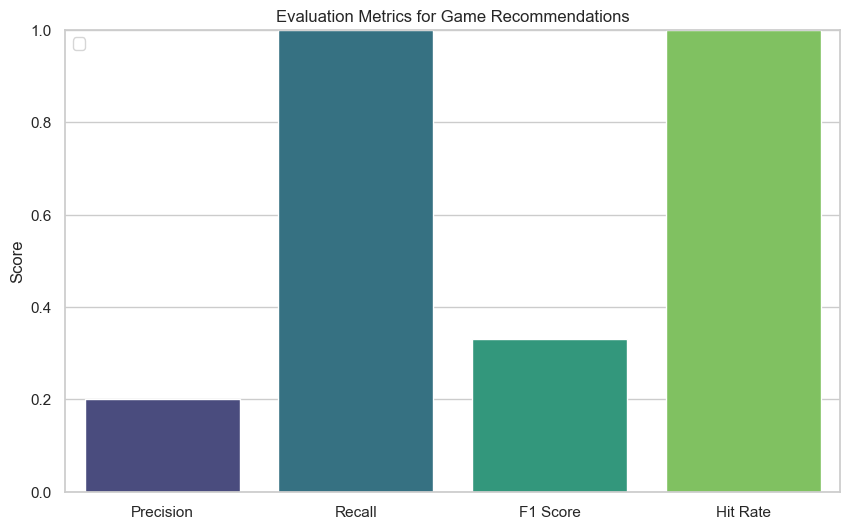

In [ ]:

metrics = {
    'Precision': 0.20,
    'Recall': 1.00,
    'F1 Score': 0.33,
    'Hit Rate': 1.00
}


plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.title('Evaluation Metrics for Game Recommendations')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

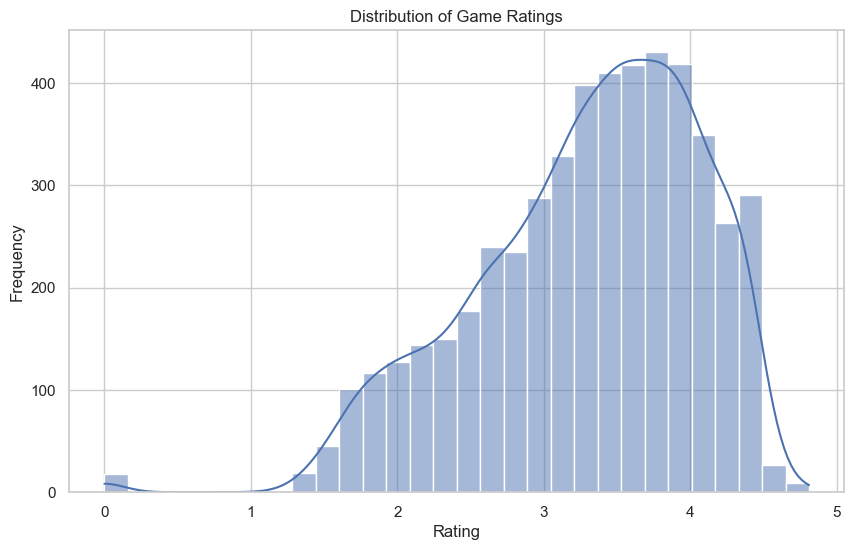

In [14]:
# Distribution of game ratings
plt.figure(figsize=(10, 6))
sns.histplot(games_df['rating'], bins=30, kde=True)
plt.title('Distribution of Game Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

/var/folders/xp/190q7gn144b1r1y55thhkym00000gn/T/ipykernel_7558/2456283195.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


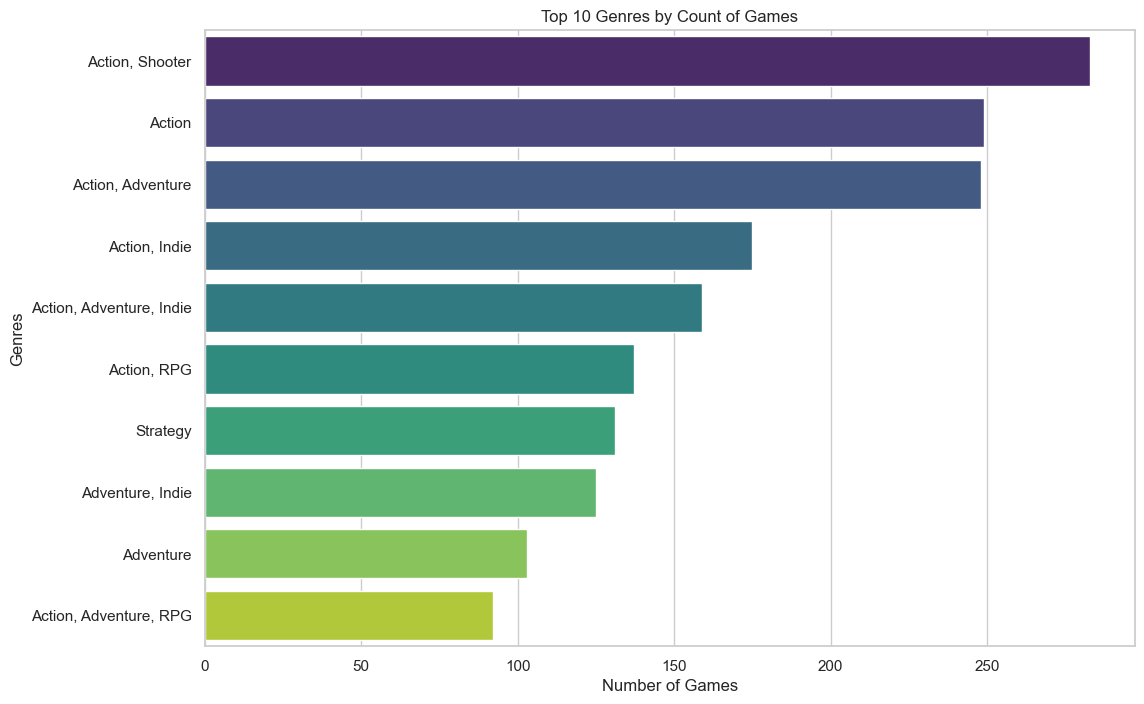

In [ ]:

plt.figure(figsize=(12, 8))
genre_counts = games_df['genres'].value_counts().head(10)
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 10 Genres by Count of Games')
plt.xlabel('Number of Games')
plt.ylabel('Genres')
plt.show()

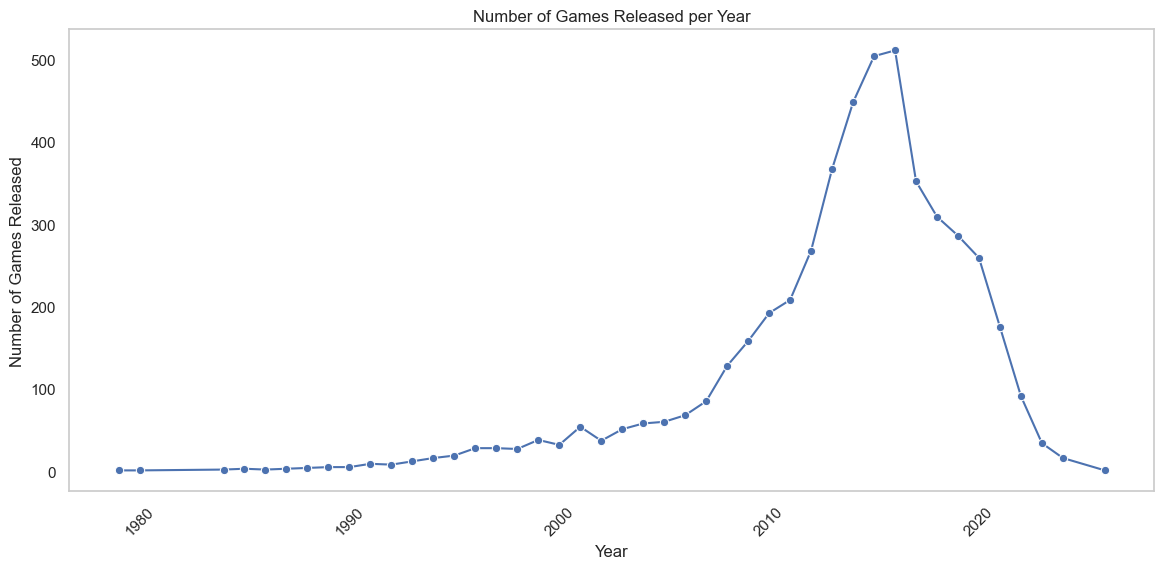

In [ ]:
games_df['released'] = pd.to_datetime(games_df['released'], errors='coerce')
games_df['release_year'] = games_df['released'].dt.year

plt.figure(figsize=(14, 6))
release_year_counts = games_df['release_year'].value_counts().sort_index()
sns.lineplot(x=release_year_counts.index, y=release_year_counts.values, marker='o')
plt.title('Number of Games Released per Year')
plt.xlabel('Year')
plt.ylabel('Number of Games Released')
plt.xticks(rotation=45)
plt.grid()
plt.show()

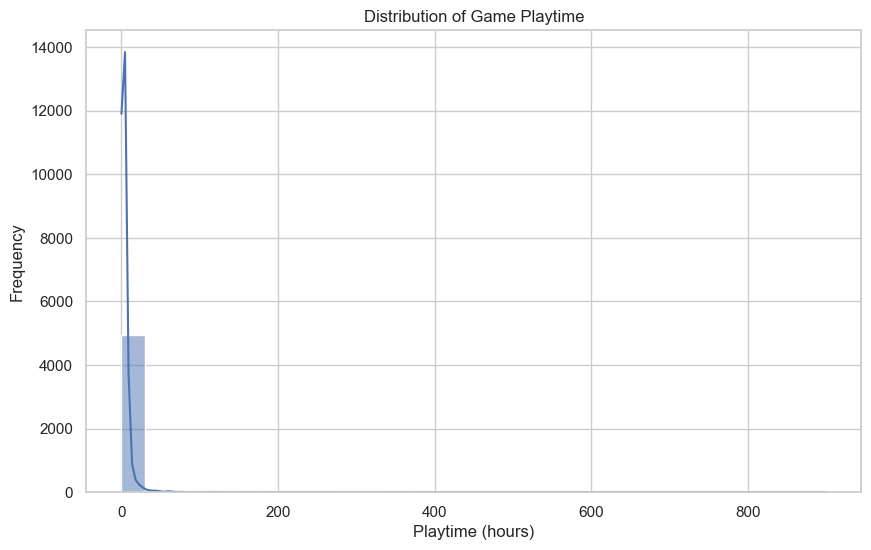

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(games_df['playtime'].dropna(), bins=30, kde=True)
plt.title('Distribution of Game Playtime')
plt.xlabel('Playtime (hours)')
plt.ylabel('Frequency')
plt.show()

/var/folders/xp/190q7gn144b1r1y55thhkym00000gn/T/ipykernel_7558/3871653649.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_counts.values, y=platform_counts.index, palette='magma')


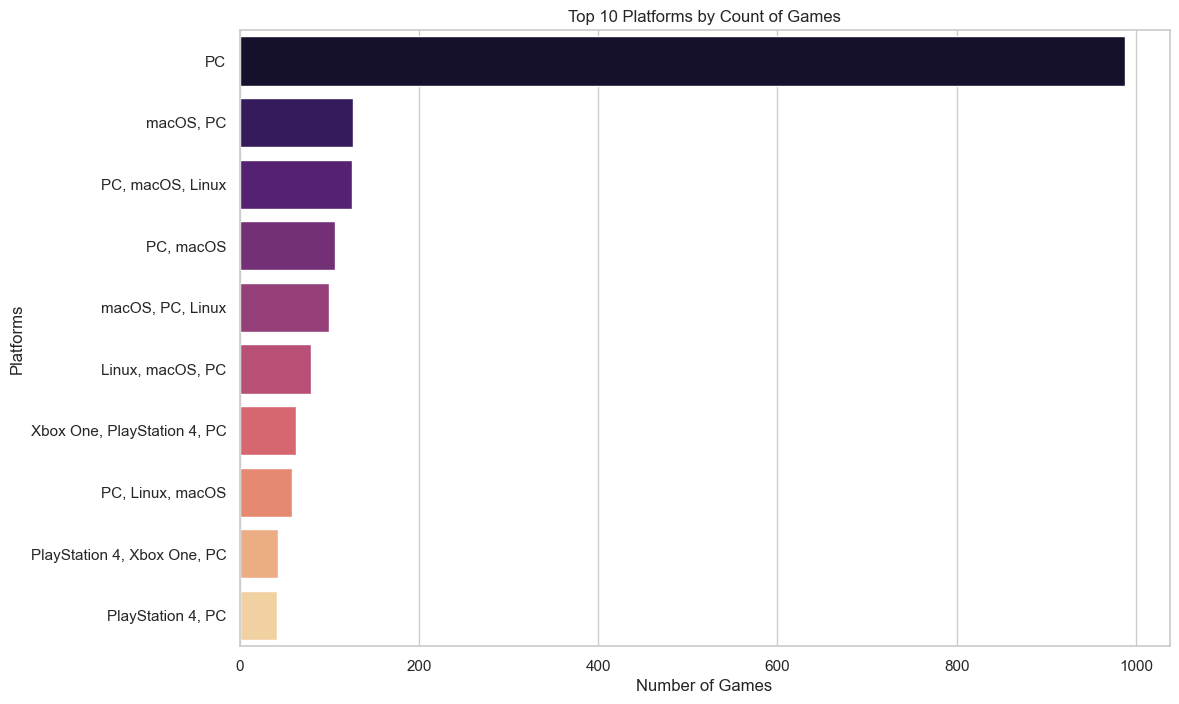

In [ ]:
plt.figure(figsize=(12, 8))
platform_counts = games_df['platforms'].value_counts().head(10)
sns.barplot(x=platform_counts.values, y=platform_counts.index, palette='magma')
plt.title('Top 10 Platforms by Count of Games')
plt.xlabel('Number of Games')
plt.ylabel('Platforms')
plt.show()